# Developing functions for computing the FFDI drought factor via the KBDI

In [1]:
import xarray as xr

import numpy as np

from src.prepare_data import _open

import matplotlib.pyplot as plt

In [2]:
%load_ext lab_black
%load_ext memory_profiler

## Cluster

In [58]:
from distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-q express",
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
client = Client(cluster)
print(f"Dask daskboard link: {client.dashboard_link}")

Dask daskboard link: http://10.6.71.72:8787/status


## Develop on some AGCD data

In [4]:
prep_data = False

if prep_data:
    agcd = _open.AGCD(["precip", "tmax"], None, None)

    precip = agcd[["precip"]].sel(time=slice("1960", None)).chunk({"time": -1})
    precip.to_zarr("agcd_precip.zarr", mode="w")

    tmax = agcd[["tmax"]].sel(time=slice("1960", None)).chunk({"time": -1})
    tmax.to_zarr("agcd_tmax.zarr", mode="w")

precip = xr.open_zarr("agcd_precip.zarr")
tmax = xr.open_zarr("agcd_tmax.zarr")

## Calculate KBDI

In [5]:
from numba import jit
import dask.array as dsa


def calculate_KBDI(precip, tmax, precip_annual, use_precip_from_previous_day=False):
    """
    Calculate the Keetch-Byram drought index, defined as:

        KBDI_n = KBDI_n-1 − Peff + ET

    Peff is the previous 24-hour rainfall amount, precip_n, decreased by an amount to allow
    for interception and/or runoff:

        Peff = precip_n - (interception/runoff)

    where the interception and/or runoff is approximated as the first 5 mm within consecutive
    days with nonzero rainfall.

    ET is the evapotransporation, estimated as:

        ET = (203.2 - KBDI_n-1) * (0.968 * exp(0.0875 * tmax_n-1 + 1.5552) - 8.3)
             -------------------------------------------------------------------- * 10 ** (-3)
                          1 + 10.88 * exp(-0.00173 * precip_annual)

    where tmax_n-1 is the previous day's max temperature and precip_annual is the mean annual
    rainfall.

    Parameters
    ----------
    precip : numpy array with shape [..., N]
        Array of daily precipitation with the last axes corresponding to the time dimension
    tmax : numpy array with shape [..., N]
        Array of max daily temperature with the last axes corresponding to the time dimension
    precip_annual : numpy array with shape [...]
        Array containing the mean annual rainfall. Usually this is computed as the average over
        a period of years corresponding the calculation period of the KBDI
    use_precip_from_previous_day : boolean, optional
        If True, use precip_n-1 to calculate KBDI_n. If False (default) use precip_n to calculate
        KBDI_n. See Notes below.

    Notes
    -----
    Daily values represent different things in different datasets. For example:
      - the daily precipitation values in AGCD represent the previous 24-hour rainfall at 9am
        and the daily tmax/tmin values represent the max/min temperatures over the subsequent
        24-hours from 9am. Thus it is appropriate to use precip_n and t_max_n-1 as above in
        order to calculate KBDI_n from the previous 24-hour rainfaill and previous day's max
        temperature.
      - both the daily precipitation and daily max temperature values are assigned to 12pm on
        a given day in CAFE and correspond to the 24-hour period centred on that time. Thus,
        one could argue that it is appropriate to use precip_n-1 and t_max_n-1 (or precip_n
        and tmax_n) to calculate KBDI_n.
      - Daily reanalysis data (e.g. JRA55) is otfen referenced against the inital forecast
        time and the precip and tmax values correspond to the 24-hour period subsequent to the
        reference time. Thus, it is appropriate to use precip_n-1 and tmax_n-1 to calculate
        KBDI_n.

    References
    ----------
    Finkele et al. 2006 (on calculation):
        https://webarchive.nla.gov.au/awa/20060903105143/http://www.bom.gov.au/bmrc/pubs/researchreports/RR119.pdf
    Holgate et al. 2017 (on calculation):
        https://www.publish.csiro.au/wf/WF16217
    Dolling et al. 2005 (on initialisation):
        https://www.sciencedirect.com/science/article/pii/S0168192305001802#bib5
    """

    @jit(nopython=True)
    def _calculate_KBDI(precip, tmax, precip_annual, use_precip_from_previous_day):
        """
        Workhorse function to calculate the KBDI

        Parameters
        ----------
        precip : numpy array with shape [..., N]
            Array of daily precipitation with the last axes corresponding to the time dimension
        tmax : numpy array with shape [..., N]
            Array of max daily temperature with the last axes corresponding to the time dimension
        precip_annual : numpy array with shape [...]
            Array containing the mean annual rainfall. Usually this is computed as the average over
            a period of years corresponding the calculation period of the KBDI
        use_precip_from_previous_day : boolean, optional
            If True, use precip_n-1 to calculate KBDI_n. If False (default) use precip_n to calculate
            KBDI_n.

        Note, I tried writing a version of this function using dask='allowed', rather than
        dask='parallelized', which is generally a better approach. However, the code relied on hacks
        to use apply_gufunc or map_blocks, so I opted for this simpler approach instead. See
        https://github.com/dougiesquire/Squire_2022_CAFE-f6/blob/1c3743d99d564a031710d03bfffe8995b3cde3f4/
            notebooks/exploratory/calculate_KBDI.ipynb
        """

        def calculate_Peff(precip, remaining_runoff):
            """
            Return Peff term in the KBDI and the remaining runoff from the daily
            rainfall
            """
            remaining_runoff = np.where(precip > 0, remaining_runoff, 5.0)
            runoff = np.where(precip < remaining_runoff, precip, remaining_runoff)
            Peff = precip - runoff
            return Peff, remaining_runoff - runoff

        def calculate_ET(KBDI_prev, tmax_prev, precip_annual):
            """
            Return evapotransporation (ET) term in the KBDI
            """
            term_1 = 203.2 - KBDI_prev
            term_2 = 0.968 * np.exp(0.0875 * tmax_prev + 1.5552) - 8.3
            term_3 = 1 + 10.88 * np.exp(-0.00173 * precip_annual)
            return 1e-3 * term_1 * term_2 / term_3

        KBDI = np.zeros_like(precip)

        remaining_runoff = 5.0 * np.ones_like(precip[..., 0])
        if not use_precip_from_previous_day:
            _, remaining_runoff = calculate_Peff(precip[..., 0], remaining_runoff)

        for i in range(1, KBDI.shape[-1]):
            precip_curr = (
                precip[..., i - 1] if use_precip_from_previous_day else precip[..., i]
            )
            Peff, remaining_runoff = calculate_Peff(precip_curr, remaining_runoff)
            ET = calculate_ET(KBDI[..., i - 1], tmax[..., i - 1], precip_annual)
            KBDI_curr = KBDI[..., i - 1] - Peff + ET

            # Limit to between 0 and 200 mm
            KBDI_curr = np.where(KBDI_curr < 0, 0, KBDI_curr)
            KBDI[..., i] = np.where(KBDI_curr > 200, 200, KBDI_curr)

        return KBDI

    KBDI = xr.apply_ufunc(
        _calculate_KBDI,
        precip,
        tmax,
        precip_annual,
        use_precip_from_previous_day,
        input_core_dims=[["time"], ["time"], [], []],
        output_core_dims=[["time"]],
        dask="parallelized",
        output_dtypes=[precip.dtype],
    )

    KBDI = KBDI.rename("KBDI")
    KBDI.attrs["long_name"] = "Keetch-Byram Drought Index (KBDI)"
    KBDI.attrs["standard_name"] = "Keetch-Byram Drought Index"

    return KBDI

In [6]:
%%time

prep_data = False

if prep_data:
    precip_annual = precip.resample(time="A").sum().mean("time")

    KBDI = calculate_KBDI(
        precip["precip"],
        tmax["tmax"],
        precip_annual["precip"],
    ).to_dataset()

    KBDI.to_zarr("agcd_KBDI.zarr", mode="w")

KBDI = xr.open_zarr("agcd_KBDI.zarr")

CPU times: user 15.5 ms, sys: 0 ns, total: 15.5 ms
Wall time: 16 ms


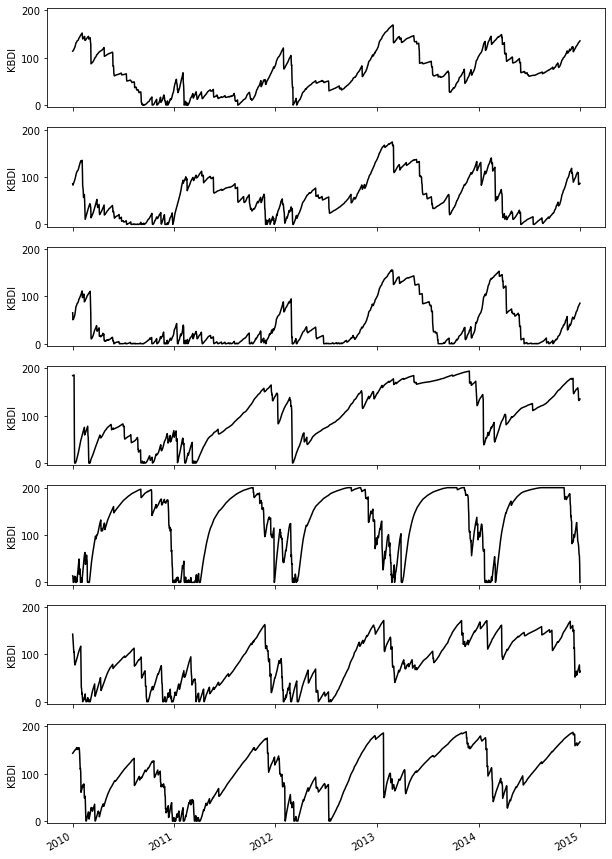

In [18]:
locations = [
    {"lon": 146.4, "lat": -34.6},
    {"lon": 148.2, "lat": -32.7},
    {"lon": 145.2, "lat": -36.9},
    {"lon": 133.6, "lat": -22.5},
    {"lon": 132.4, "lat": -14.5},
    {"lon": 148.2, "lat": -23.6},
    {"lon": 146.3, "lat": -20.0},
]

fig, axs = plt.subplots(len(locations), 1, sharex=True, figsize=(10, 15))
for ax, loc in zip(axs, locations):
    KBDI["KBDI"].sel(loc, method="nearest").sel(time=slice("2010", "2014")).plot(
        ax=ax, color="k"
    )
    ax.set_ylim(-5, 205)
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("KBDI")

## Calculate Drought factor

In [59]:
def calculate_drought_factor(SMD, precip, limiting_function=None, auto_rechunk=True):
    """
    Calculate the Griffiths (1998) drought factor based on the soil moisture deficit:

        DF = 10.5 * (1 - exp(-(SMD + 30) / 40)) *  41 x**2 + x
                                                 ---------------
                                                 40*x**2 + x + 1

    Parameters
    ----------
    SMD : xarray DataArray
        Values of the daily soil moisture deficit (often KBDI)
    precip : xarray DataArray
        Values of daily precipitation.
    limiting_function : str, optional
        The approach to use to limit the values of the drought factor. Options are:
        - None; x is estimated from the rainfall over the previous 20 days and the time
          since it fell:
                      N**1.3
                  --------------    if N >= 1 & P > 2mm
                  N**1.3 + P - 2
              x =     0.8**1.3
                  ----------------  if N = 0  & P > 2mm
                  0.8**1.3 + P - 2
                         1          if P < 2mm
          see Finkele et al. 2006 for details on how P and N are estimated from daily rainfall
        - 'xlim'; x is estimated as above and limited to:
                            1
                     ----------------       if SMD < 20
                     1 + 0.1135 * SMD
              xlim =        75
                     ---------------------  if SMD >= 20
                     270.525 - 1.267 * SMD
        - 'discrete'; x is estimated as above but the resulting drought factor is limited to the
          following values:
                   6   if 0   <  SMD < 25
                   7   if 25  <= SMD < 42
              DF = 8   if 42  <= SMD < 65
                   9   if 65  <= SMD < 100
                   10  if 100 <= SMD <= 200
    auto_rechunk : boolean, optional
        If True, automatically rechunk precip for better memory management. Note that this will
        mean the output will be chunked differently than the inputs.
    """

    def _calculate_x(precip_windows):
        """
        Return the minimum value of the x function for a given preciptation window

        This function is vectorized and very memory hungry
        """

        def _x_function(P, N):
            """
            Calculate x from the accumulated rainfall within an event and the number
            of days N since the large daily rainfall in that event
            """
            x = (N**1.3) / (N**1.3 + P - 2.0)
            x = np.where(N == 0.0, (0.8**1.3) / (0.8**1.3 + P - 2.0), x)
            x = np.where(P <= 2.0, 1.0, x)
            return x

        # Label events (consecutive elements with P > 2) along the window axis
        events = precip_windows > 2.0
        event_cumsum = np.cumsum(events, axis=-1, dtype=np.int32)[..., 1:]
        shifted_event_cumsum = np.cumsum(
            np.where(events[..., :-1], events[..., 1:], False), axis=-1, dtype=np.int32
        )
        labelled_events = np.where(
            events[..., 1:], event_cumsum - shifted_event_cumsum, 0
        )

        # Loop over all events and compute the minimum x
        if isinstance(precip_windows, dsa.Array):
            # 10 is the max number of events in a 20-day period. Calculating the actual
            # max number of events will trigger computation
            max_events = 10
        else:
            max_events = np.max(labelled_events)
        for label in range(1, max_events + 1):
            P = np.sum(
                np.where(labelled_events == label, precip_windows[..., 1:], 0), axis=-1
            )
            N = 20 - np.argmax(
                np.where(labelled_events == label, precip_windows[..., 1:], 0), axis=-1
            )
            if label == 1:
                x = _x_function(P, N)
            else:
                x = np.minimum(x, _x_function(P, N))

        return x

    def _calculate_DF(SMD, x):
        """Calculate the drought factor using the Griffiths formula"""
        term_1 = 10.5 * (1 - np.exp(-(SMD + 30) / 40))
        term_2 = 41 * x**2 + x
        term_3 = 40 * x**2 + x + 1
        return term_1 * term_2 / term_3

    def _apply_limits(x, limits):
        """
        Apply limit on x, where limits is a list of conditions and corresponding
        limits, e.g. [(condition_1, limit_1), (condition_2, limit_2)...]
        """
        for condition, limit in limits:
            x = xr.where(condition & (x > limit), limit, x)
        return x

    def _apply_xlim(x, SMD):
        """Limit x using the 'xlim' function"""
        cond_1 = (SMD < 20, 1 / (1 + 0.1135 * SMD))
        cond_2 = (SMD >= 20, 75 / (270.525 - 1.267 * SMD))
        return _apply_limits(x, [cond_1, cond_2])

    def _apply_discrete(DF, SMD):
        """Limit DF using the 'discrete' function"""
        cond_1 = ((SMD > 0) & (SMD < 25), 6)
        cond_2 = ((SMD >= 25) & (SMD < 42), 7)
        cond_3 = ((SMD >= 42) & (SMD < 65), 8)
        cond_4 = ((SMD >= 65) & (SMD < 100), 9)
        cond_5 = ((SMD >= 100) & (SMD <= 200), 10)
        return _apply_limits(DF, [cond_1, cond_2, cond_3, cond_4, cond_5])

    # Use a window size of 21 as the first element is dropped in the calculation of x
    precip_rolling = precip.rolling(time=21).construct(window_dim="window")

    # Adjust chunk size otherwise chunks are enormous
    if isinstance(precip_rolling.data, dsa.Array) & auto_rechunk:
        precip_rolling = precip_rolling.chunk({"time": "auto"})

    x = xr.apply_ufunc(
        _calculate_x,
        precip_rolling,
        input_core_dims=[["window"]],
        dask="allowed",
    )

    if limiting_function is None:
        DF = _calculate_DF(SMD, x)
    elif limiting_function == "xlim":
        DF = _calculate_DF(SMD, _apply_xlim(x, SMD))
    elif limiting_function == "discrete":
        DF = _apply_discrete(_calculate_DF(SMD, x), SMD)

    DF = DF.rename("DF")
    DF.attrs["long_name"] = "Griffiths Drought Factor (DF)"
    DF.attrs["standard_name"] = "drought_factor"
    DF.attrs["units"] = "-"

    return DF

CPU times: user 4.19 s, sys: 236 ms, total: 4.42 s
Wall time: 50.6 s


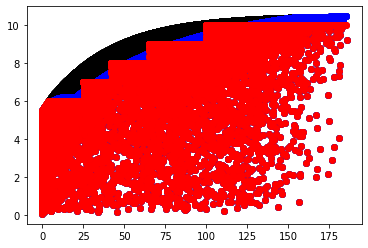

In [60]:
%%time

KBDI_test = KBDI["KBDI"].sel(locations[0])
precip_test = precip["precip"].sel(locations[0])

a = calculate_drought_factor(KBDI_test, precip=precip_test)
b = calculate_drought_factor(KBDI_test, precip=precip_test, limiting_function="xlim")
c = calculate_drought_factor(
    KBDI_test, precip=precip_test, limiting_function="discrete"
)

plt.plot(KBDI_test, a, "ko")
plt.plot(KBDI_test, b, "bo")
plt.plot(KBDI_test, c, "ro")

## How does this run on the full dataset?

The vectorized approach is obviously very memory hungry. I had to add in automatic chunking along the time dimension after constructing the rolling object to get it to work. I also tried:
 - using `xr.apply_ufunc(..., vectorize=True)` with a `calculate_x` function that operates on vectors - this was prohibitively slow
 - using `xr.apply_ufunc(..., dask="allowed")` and wrapping the (unvectorized) `calculate_x` function with numba `guvectorize` - this failed with an uninterpretable serialization error
 - using `xr.apply_ufunc(..., dask="allowed")` and mapping the (unvectorized) `calculate_x` function through `dask.gufunc.apply_gufunc` with `vectorize=True` - this was also prohibitely slow
 - using `xr.apply_ufunc(..., dask="allowed")` and mapping the (unvectorized) `calculate_x` function through `apply_along_axis` - this was also prohibitively slow

In [61]:
%%time

prep_data = True

if prep_data:
    DF = calculate_drought_factor(
        KBDI["KBDI"],
        precip["precip"],
        limiting_function="discrete",
    ).to_dataset()

    DF.to_zarr("agcd_DF.zarr", mode="w")

DF = xr.open_zarr("agcd_DF.zarr")

CPU times: user 18min 47s, sys: 1min 5s, total: 19min 52s
Wall time: 48min 41s


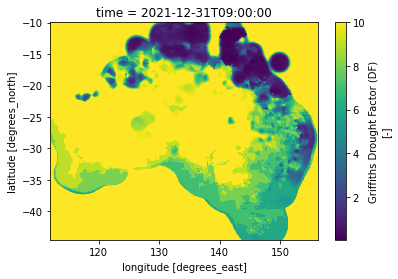

In [62]:
DF["DF"].isel(time=-1).plot()

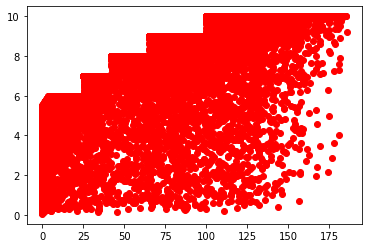

In [63]:
loc = locations[0]
plt.plot(KBDI["KBDI"].sel(loc), DF["DF"].sel(loc), "ro")